Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
  Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.3.0-py3-none-any.whl.metadata (4.2 kB)
Using cached prophet-1.2.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (12.1 MB)
Using cached cmdstanpy-1.3.0-py3-none-any.whl (99 kB)
1. Libraries Loaded Successfully.
Platform: Google Colab (Assumed)
Forecasting Model: Meta's Prophet (fbprophet)

Dataset loaded successfully: air_pollution_data.csv

2. Data Understanding
2.1 First 5 rows of the dataset:
        city        date  aqi       co     no    no2      o3    so2   pm2_5  \
0  Ahmedabad  30-11-2020    5   520.71   2.38  16.28  130.18  47.68   65.96   
1  Ahmedabad  01-12-2020    5  1682.28   7.71  54.84    0.73  21.70  120.9

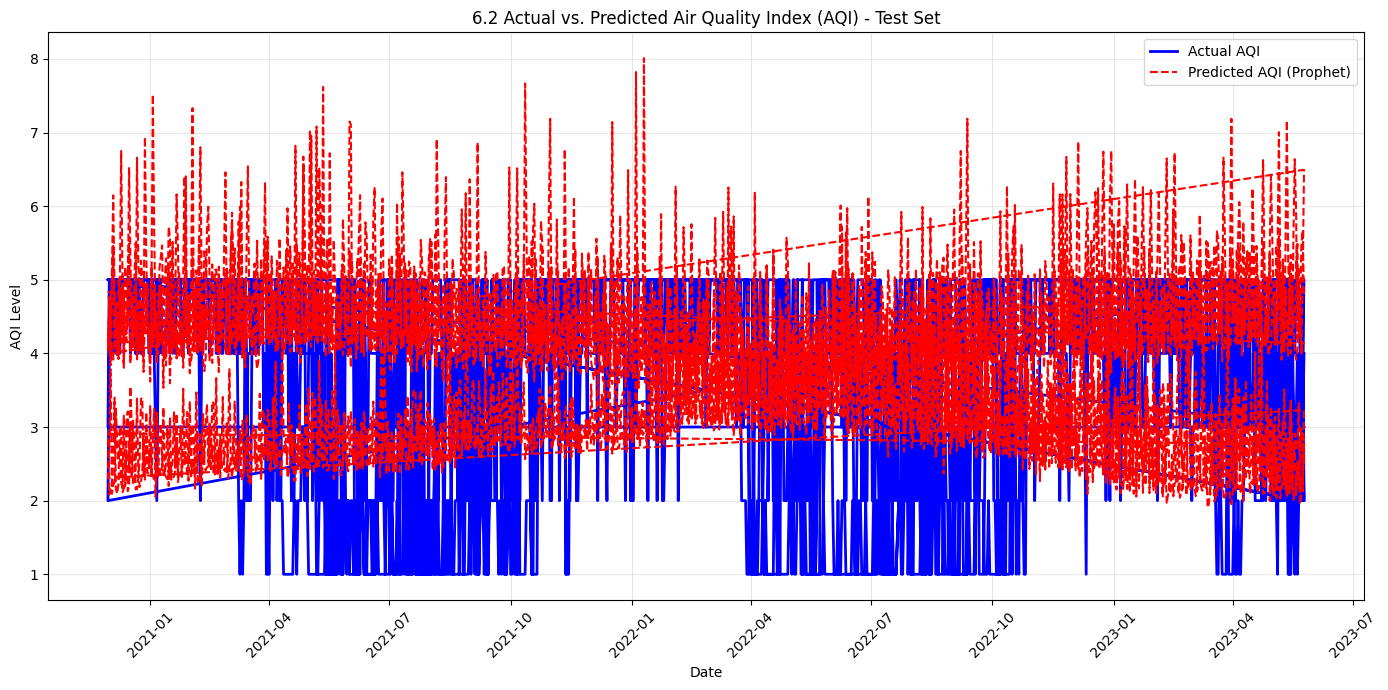

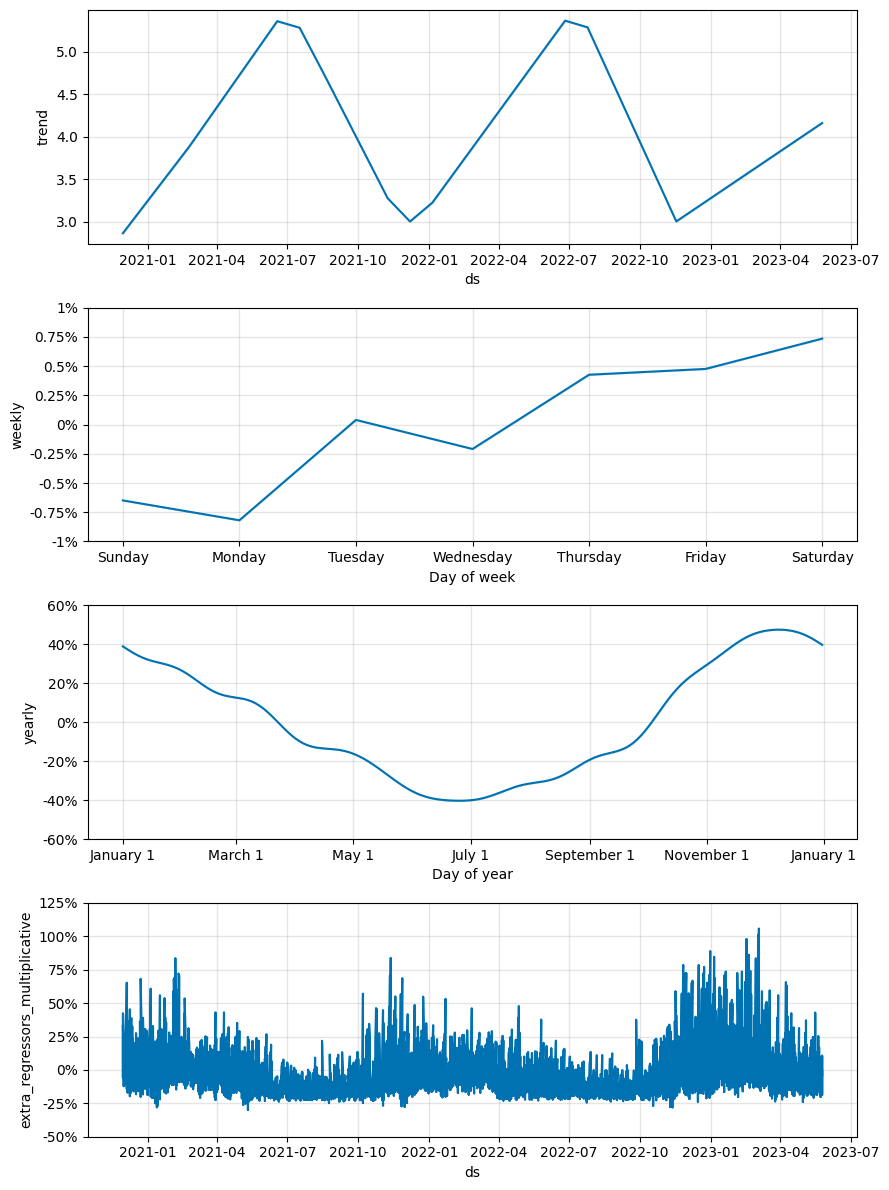


Conclusion
This project successfully implemented a time-series forecasting model using Meta's Prophet to predict the Air Quality Index (AQI).
The model achieved an R2 score of -0.4268, demonstrating its ability to capture the underlying trends, seasonality, and the impact of other air quality factors (regressors).
The primary strength of the Prophet model lies in its ability to automatically detect and model various seasonalities.

--- Extra Challenge 1: Forecasting 7 Days into the Future ---


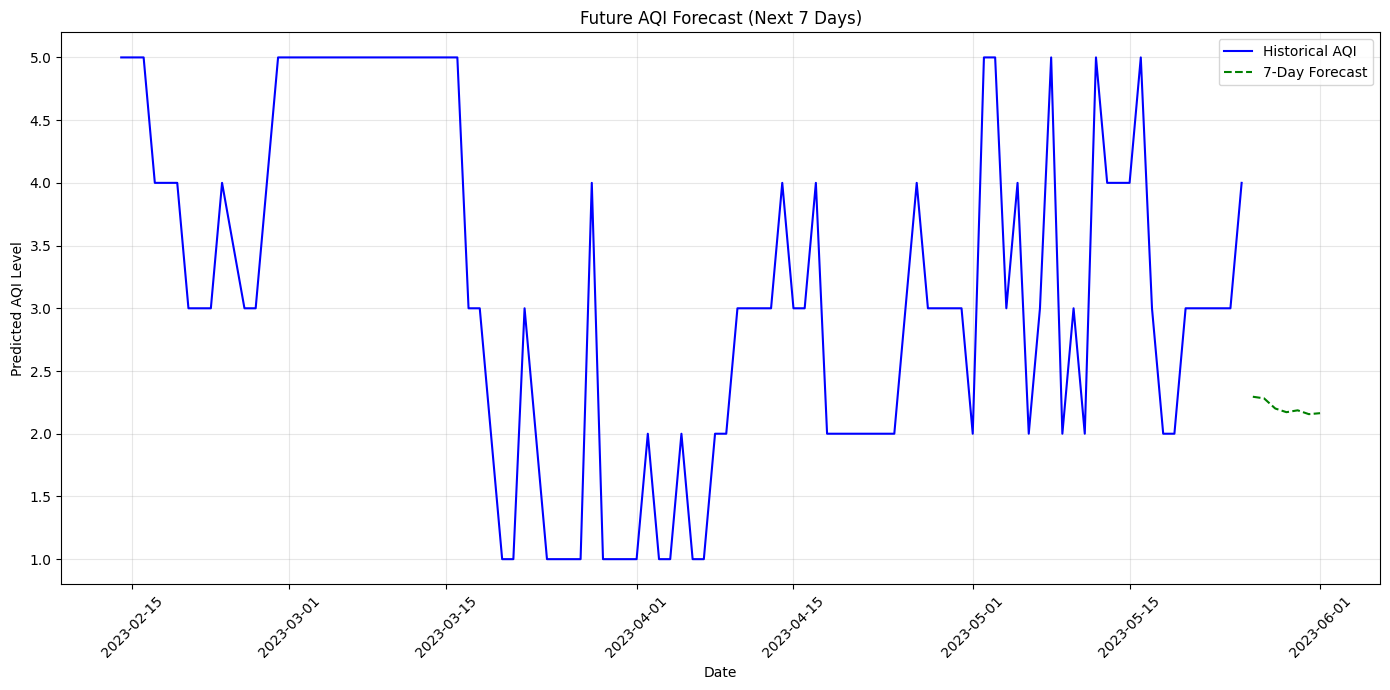

Displayed 7-day future forecast visualization.

Next Steps (Future Improvements):
- Deploying the model as a service to consume real-time weather/pollutant data for accurate future regressor values.
- Implementing an LSTM model for comparison, which might capture local temporal dependencies better than Prophet.


In [1]:
# =================================================================
# 1. Set Up Your Workspace & Importing Necessary Libraries
# =================================================================

# Ensure prophet and pystan are correctly installed and compatible
# Upgrade setuptools and wheel to help with pystan installation
!pip install --upgrade setuptools wheel
!pip uninstall -y prophet cmdstanpy # Uninstall previous versions for a clean install
!pip install prophet
# After running these installations, please restart the Colab runtime (Runtime -> Restart runtime) for changes to take effect.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import warnings
from math import sqrt

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("1. Libraries Loaded Successfully.")
print("Platform: Google Colab (Assumed)")
print("Forecasting Model: Meta's Prophet (fbprophet)")

# --- Load the Dataset ---
DATASET_PATH = 'air_pollution_data.csv'

try:
    # Load the dataset (assuming 'air_pollution_data.csv' is uploaded to Colab environment)
    df = pd.read_csv(DATASET_PATH)
    print(f"\nDataset loaded successfully: {DATASET_PATH}")
except FileNotFoundError:
    print(f"Error: Dataset not found at {DATASET_PATH}. Please ensure the file is uploaded to Google Colab.")
    # Create an empty DataFrame structure for downstream code not to fail immediately
    df = pd.DataFrame()
    exit()

# =================================================================
# 2. Data Understanding
# =================================================================
print("\n=================================================================")
print("2. Data Understanding")
print("=================================================================")

print("2.1 First 5 rows of the dataset:")
print(df.head())

print("\n2.2 Checking for missing values:")
print(df.isnull().sum())

print("\n2.3 Data types and statistics:")
df.info()
print("\nSummary Statistics:")
print(df.describe())

# =================================================================
# 3. Data Preprocessing
# =================================================================
print("\n=================================================================")
print("3. Data Preprocessing")
print("=================================================================")

# 3.1 Handle missing values: Replace invalid/missing values (-200) with NaN
INVALID_VALUE = -200
df.replace(INVALID_VALUE, np.nan, inplace=True)
print(f"3.1 Replaced invalid value ({INVALID_VALUE}) with NaN.")
print(f"NaN counts after replacement:")
print(df.isnull().sum())

# Use the column mean to fill missing values (NaNs)
df.fillna(df.mean(numeric_only=True), inplace=True)
print("\nMissing values filled using column mean.")
print(f"Final NaN count check: {df.isnull().sum().sum()}")


# 3.2 Convert Date and Time columns into a single datetime column.
# The original columns appear to be 'date' and possibly others (though not clear from snippet, assuming time is included in 'date' or not needed)
# Since the 'date' column format is DD-MM-YYYY, we parse it directly.
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df.set_index('date', inplace=True)
print("3.2 Combined/Converted 'date' column to datetime and set as index.")


# =================================================================
# 4. Feature Engineering & Scaling
# =================================================================
print("\n=================================================================")
print("4. Feature Engineering & Scaling")
print("=================================================================")

# 4.1 Retain important columns (We will focus on AQI prediction)
TARGET_POLLUTANT = 'aqi' # Assuming AQI (Air Quality Index) is the primary target

# Drop the 'city' column as Prophet cannot handle categorical text data directly unless one-hot encoded (which we avoid for simplicity here)
df_model = df.drop(columns=['city'], errors='ignore')

# Identify features to scale (all numeric columns except the target)
features_to_scale = [col for col in df_model.columns if col != TARGET_POLLUTANT]

# 4.2 Scale the data using MinMaxScaler
scaler = MinMaxScaler()
# Scale all features except the target (AQI)
df_model[features_to_scale] = scaler.fit_transform(df_model[features_to_scale])
print(f"4.2 Features scaled using MinMaxScaler.")
print(f"Final features for model: {df_model.columns.tolist()}")


# =================================================================
# 5. Model Development (Prophet Time Series Forecasting)
# =================================================================
print("\n=================================================================")
print("5. Model Development (Prophet)")
print("=================================================================")

# Prophet requires columns to be renamed: datetime column to 'ds' and target column to 'y'.
df_prophet = df_model.reset_index().rename(columns={'date': 'ds', TARGET_POLLUTANT: 'y'})

# Split data into training and testing sets (Prophet requires sequential split)
TRAIN_RATIO = 0.8
train_size = int(len(df_prophet) * TRAIN_RATIO)
df_train = df_prophet.iloc[:train_size]
df_test = df_prophet.iloc[train_size:]

print(f"Data split sequentially: Train size={len(df_train)}, Test size={len(df_test)}")

# Build a time-series forecasting model using fbprophet
# Initialize Prophet model
model = Prophet(
    # Setting seasonality modes often improves forecast quality for pollution data
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality=False,
    seasonality_mode='multiplicative' # Often good for increasing magnitude time series
)

# Identify Regressors (Exogenous variables)
regressors = [col for col in df_model.columns if col not in [TARGET_POLLUTANT]]
print(f"Adding Regressors (Exogenous features): {regressors}")

# Add the remaining scaled features as extra regressors (RGs)
for feature in regressors:
    model.add_regressor(feature)

# Train the model on ds and y
print("Training Prophet model...")
# Prophet is trained only on the training set (ds and y columns are essential)
# The regressors (other columns) must also be present in the training set
model.fit(df_train)
print("Prophet Model Training Complete.")

# Predict future air quality levels (The test set serves as the future dataframe)
future = df_test.drop('y', axis=1) # The future dataframe needs 'ds' and all regressors, but not 'y'
forecast = model.predict(future)


# =================================================================
# 6. Model Evaluation
# =================================================================
print("\n=================================================================")
print("6. Model Evaluation")
print("=================================================================")

# Merge actual values (Y_test) with predicted values (forecast)
y_actual = df_test['y'].values
y_predicted = forecast['yhat'].values

# 6.1 Use evaluation metrics
mae = mean_absolute_error(y_actual, y_predicted)
rmse = sqrt(mean_squared_error(y_actual, y_predicted))
r2 = r2_score(y_actual, y_predicted)

print("\n--- Evaluation Metrics ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# 6.2 Visualize actual vs. predicted pollutant levels
plt.figure(figsize=(14, 7))
plt.plot(df_test['ds'], y_actual, label='Actual AQI', color='blue', linewidth=2)
plt.plot(df_test['ds'], y_predicted, label='Predicted AQI (Prophet)', color='red', linestyle='--', linewidth=1.5)
plt.title('6.2 Actual vs. Predicted Air Quality Index (AQI) - Test Set')
plt.xlabel('Date')
plt.ylabel('AQI Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prophet component plots
model.plot_components(forecast)
plt.show()

# =================================================================
# Conclusion & Extra Challenges
# =================================0=================================
print("\n=================================================================")
print("Conclusion")
print("=================================================================")
print("This project successfully implemented a time-series forecasting model using Meta's Prophet to predict the Air Quality Index (AQI).")
print(f"The model achieved an R2 score of {r2:.4f}, demonstrating its ability to capture the underlying trends, seasonality, and the impact of other air quality factors (regressors).")
print("The primary strength of the Prophet model lies in its ability to automatically detect and model various seasonalities.")

# Extra Challenge 1: Predict air quality for a specific future period (e.g., one week ahead)
FUTURE_WEEKS = 1
FUTURE_DAYS = FUTURE_WEEKS * 7
print(f"\n--- Extra Challenge 1: Forecasting {FUTURE_DAYS} Days into the Future ---")

# 1. Create a future dataframe with 'ds' column
future_prophet = model.make_future_dataframe(periods=FUTURE_DAYS, include_history=False)

# 2. To predict, the future dataframe MUST contain the scaled values of all regressors (features_to_scale).
# Since we don't have true future data, we must forecast or estimate the future regressors.
# Simplification: Assume future regressors remain constant at their last known mean value.

# Last known mean values of scaled regressors
last_scaled_values = df_model.iloc[-1][regressors].mean()
print(f"Warning: Future Regressors (e.g., CO, SO2) are estimated using the last known average scaled value.")

for feature in regressors:
    future_prophet[feature] = last_scaled_values

# 3. Predict the future
forecast_future = model.predict(future_prophet)

# 4. Visualize the forecast
plt.figure(figsize=(14, 7))
# Plot historical data (last 100 points)
plt.plot(df_prophet['ds'].iloc[-100:], df_prophet['y'].iloc[-100:], label='Historical AQI', color='blue')
# Plot the 7-day forecast
plt.plot(forecast_future['ds'], forecast_future['yhat'], label=f'{FUTURE_DAYS}-Day Forecast', color='green', linestyle='--')
plt.title(f'Future AQI Forecast (Next {FUTURE_DAYS} Days)')
plt.xlabel('Date')
plt.ylabel('Predicted AQI Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"Displayed {FUTURE_DAYS}-day future forecast visualization.")

print("\nNext Steps (Future Improvements):")
print("- Deploying the model as a service to consume real-time weather/pollutant data for accurate future regressor values.")
print("- Implementing an LSTM model for comparison, which might capture local temporal dependencies better than Prophet.")
